# **Diabetic Retina Model using ResNet**

---

this is trash code
Dataset: https://www.kaggle.com/c/aptos2019-blindness-detection/data

## 1.1 Uploading Data



In [ ]:
# importing some libraries (not all are currently used)
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import imageio
import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar


# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


In [ ]:
# Load the CSV file containing image filenames and labels
main_dir = ''

train_img = main_dir + 'train_images'
test_img = main_dir + 'test_images'

train_csv = main_dir + 'train.csv'
test_csv = main_dir + 'test.csv'

train_data = pd.read_csv(train_csv)

# Basic preprocessing of labels
train_data['diagnosis'] = train_data['diagnosis'].astype('str')  # Convert labels to strings

## 1.2 Dataset Analysis

In [ ]:
train_data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
train_data['diagnosis'] = train_data['diagnosis'].astype('int64')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


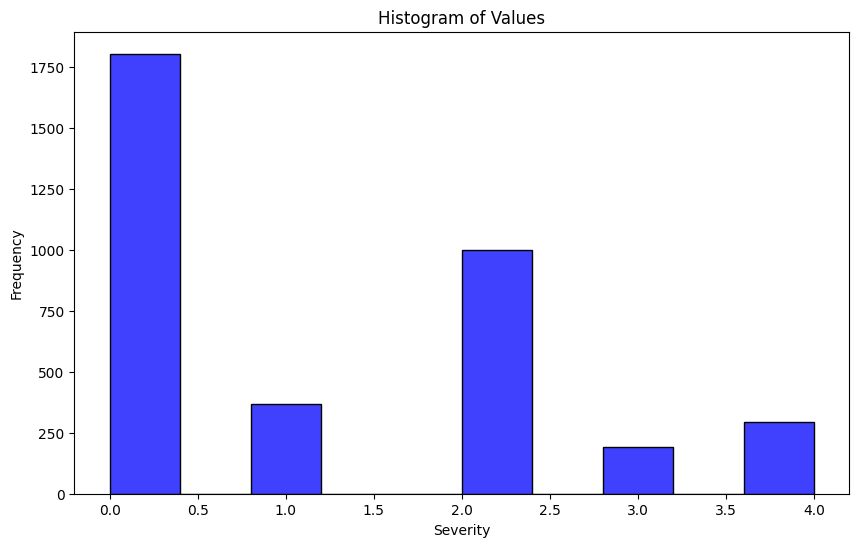

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(train_data['diagnosis'], bins=10, kde=False, color='blue')  # Customize bins, KDE, and color

# Customize the plot
plt.title('Histogram of Values')
plt.xlabel('Severity')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### *Of note the histogram values are slightly skewed to the right. There seems to be two peaks at 0.0 and 2.0 meaning there is an abudance of less extreme severities. Augmentation should sample from all equally*

## 1.3 Data Loading (checking if it works)

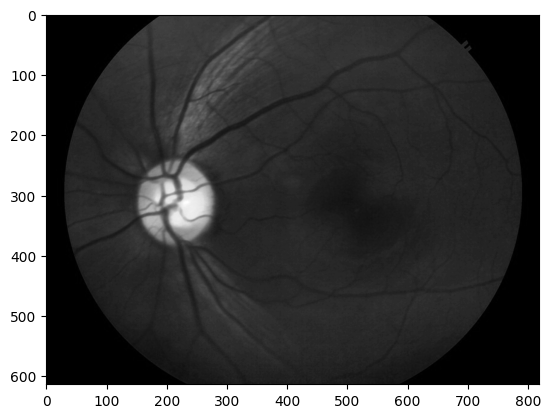

In [ ]:
image_path = train_img + '/cfdbaef73a8b.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )
plt.imshow(image, cmap='gray')
plt.show()

# **Pre Processing**

---





## 2.1 Data Prep

KeyboardInterrupt: 

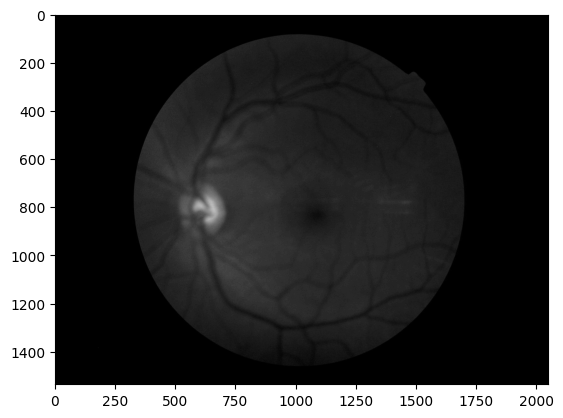

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

# turning ALL images greyscale
#(except some id_codes of the train.csv text file do not match with any image in the test folder,
# so rn just doing a random range w/ couple values that do work)
# for example, indices 1-2, 4, 6, 7, 13 do not work

for i in range(train_data.size):
  image_id = train_data.iloc[i].id_code;
  curr_image_path = "train_images/{}.png".format(image_id)
  grayscale_dir = 'test_images_grayscale'


  # BOAZ - images from your csv is not in train_images
  # ex. 001639a390f0 is in train.csv but there is no 001639a390f0.png in train_images
  img_name = f'{image_id}.png'
  if img_name not in os.listdir('train_images'):
    raise Exception(f'{img_name} not found in train_images')
  # Conclusion: find out what is going on with train_images or train.csv


  img = cv2.imread(curr_image_path)
  #print(curr_image_path) # for debugging purposes
  #print(type(img))
  grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  plt.imshow(grey_img, cmap='gray')
  plt.savefig(grayscale_dir + f'/{image_id}' + '.png', bbox_inches = 'tight')
  #plt.show()

## 2.2 Loading the Dataset





In [ ]:
class APTOSDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.data_frame)
    def __getitem__(self, idx):
      img_name = os.path.join(self.root_dir, '', self.data_frame.iloc[idx, 0] + '.png')
      image = Image.open(img_name).convert('RGB')
      label = self.data_frame.iloc[idx, 1]
      if self.transform:
            image = self.transform(image)
      return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = APTOSDataset(
    root_dir="train_images",
    csv_file="train.csv",
    transform=ToTensor()
)

test_data = APTOSDataset(
    root_dir="test_images",
    csv_file="test.csv",
    transform=ToTensor()
)


## 2.3 Dataloader

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar

train_dataset = APTOSDataset(csv_file='train.csv', root_dir='', transform=transform)
test_dataset = APTOSDataset(csv_file='test.csv', root_dir='', transform=transform)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
train_loader = DataLoader(training_data, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **CNN Model**


---



In [ ]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


In [ ]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # Forward pass
        outputs = model(train)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

    # Testing the model

        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data.cpu())
            iteration_list.append(count)
            accuracy_list.append(accuracy.cpu())

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: DataLoader worker (pid(s) 43699) exited unexpectedly